In [41]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

In [43]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [45]:
# Instead of using argparse, manually set parameters
image_path = r"D:\Project\dataset\Amanita citrina\2medium.jpeg"  # Set the path to your image
width = 500  # Define the width

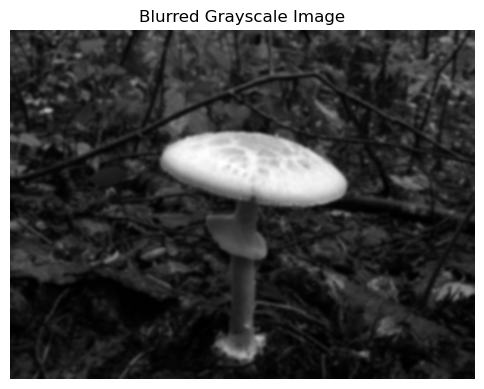

In [47]:
# Load the image
image = cv2.imread(image_path)

# Check if the image was loaded
if image is None:
    raise FileNotFoundError(f"Error: Could not load image at {image_path}")

# Convert to grayscale and apply Gaussian blur
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# Display the image using Matplotlib (alternative to cv2.imshow)
plt.figure(figsize=(6,6))
plt.imshow(gray, cmap='gray')
plt.axis("off")  # Hide axes
plt.title("Blurred Grayscale Image")
plt.show()

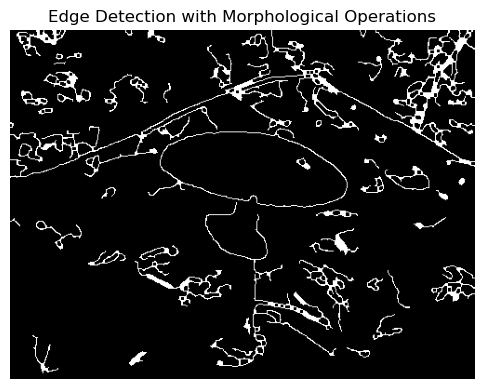

In [49]:
# Perform edge detection
edged = cv2.Canny(gray, 30, 150)

# Apply dilation followed by erosion (closing gaps)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# Display the edges using Matplotlib
plt.figure(figsize=(6,6))
plt.imshow(edged, cmap='gray')
plt.axis("off")  # Hide axes
plt.title("Edge Detection with Morphological Operations")
plt.show()

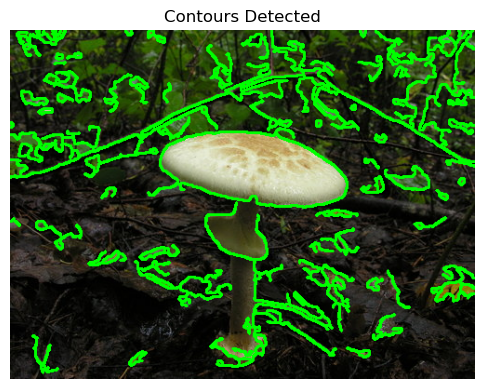

In [51]:
# Find contours
cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours from left to right manually (if imutils is not available)
cnts = sorted(cnts, key=lambda c: cv2.boundingRect(c)[0])

# Initialize pixels per metric calibration variable
pixelsPerMetric = None

# Draw contours
contour_image = image.copy()
cv2.drawContours(contour_image, cnts, -1, (0, 255, 0), 2)

# Display the contours using Matplotlib
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Contours Detected")
plt.show()

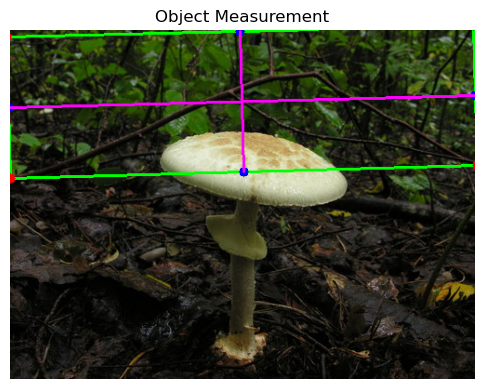

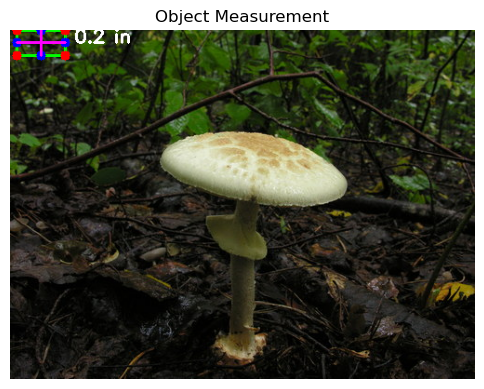

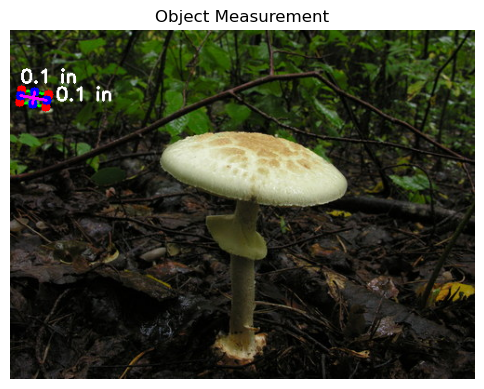

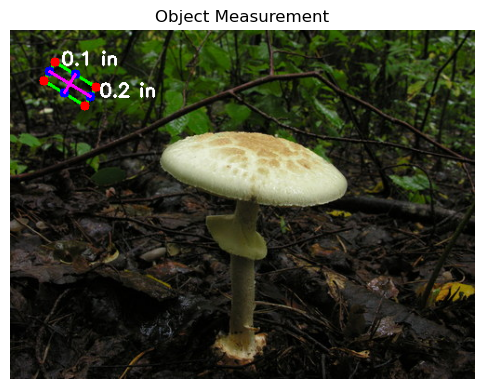

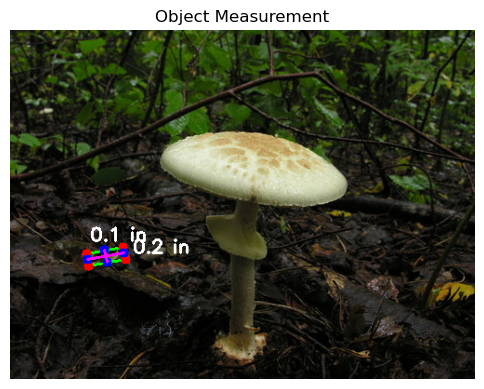

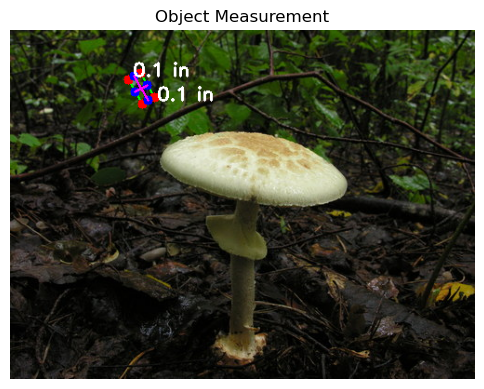

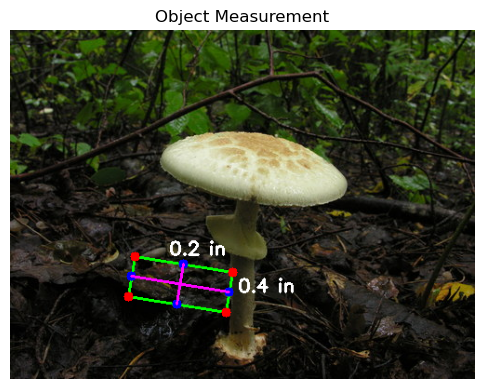

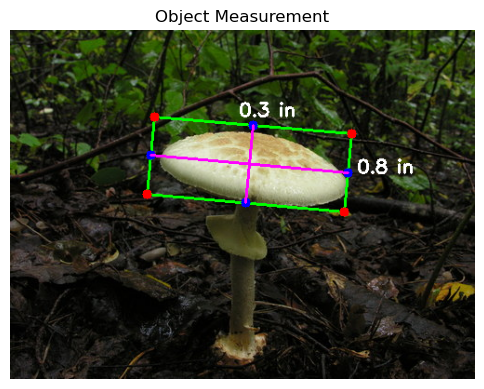

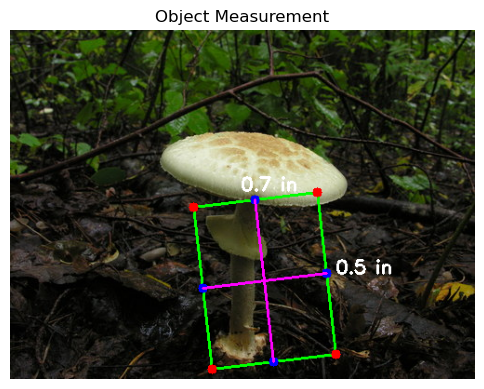

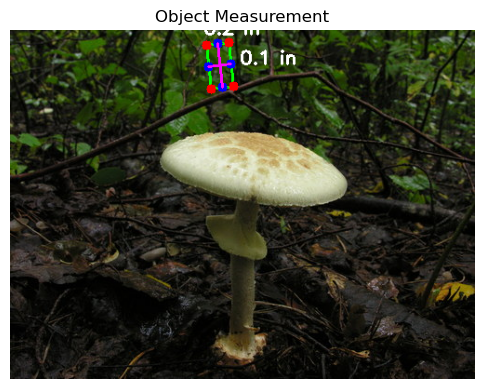

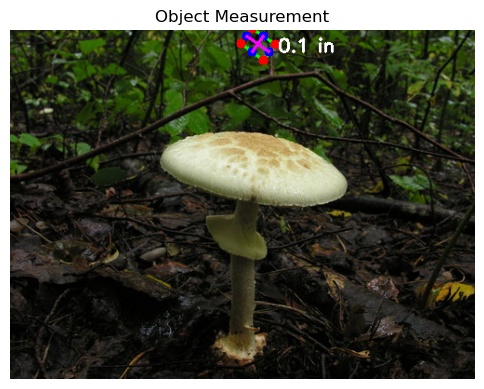

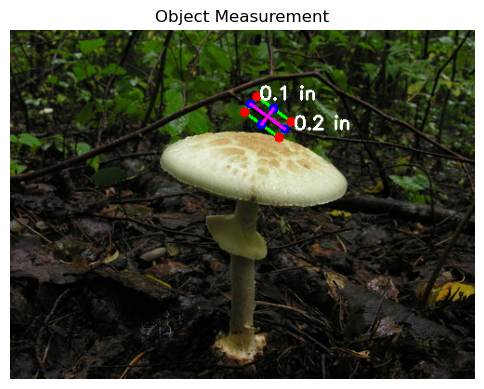

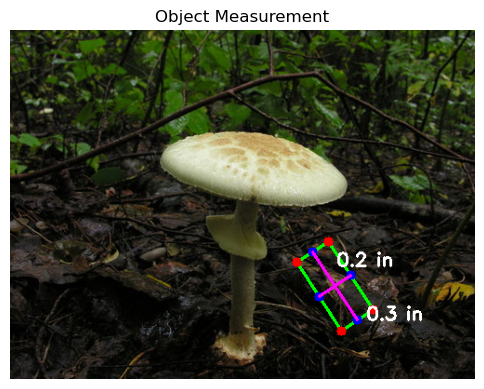

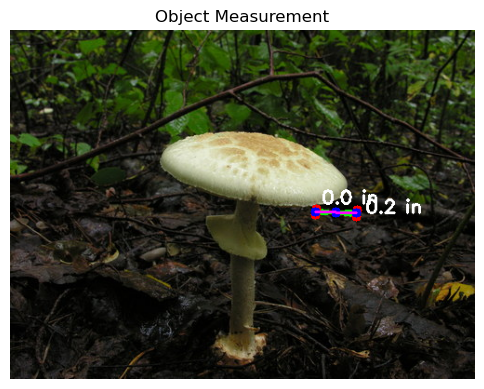

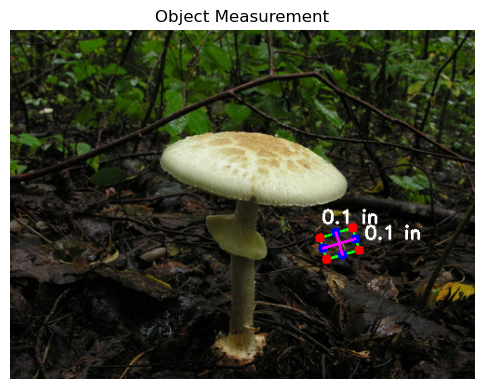

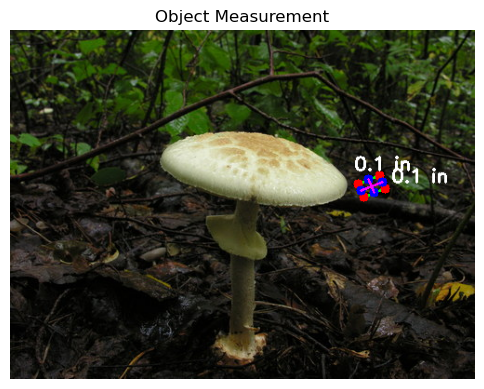

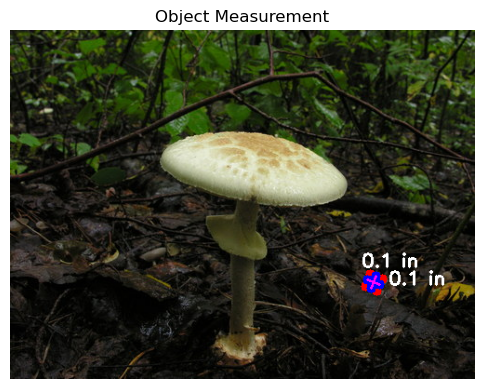

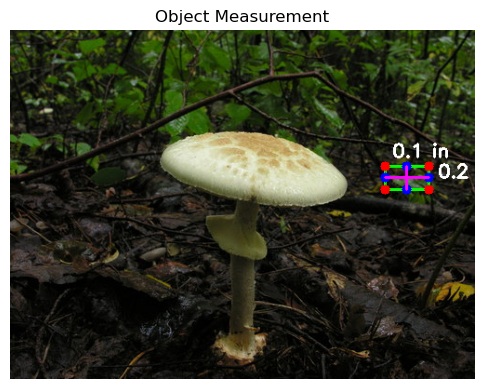

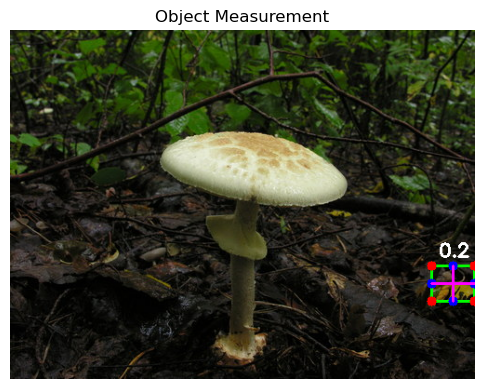

In [53]:
# Set a known object width (adjust this for your reference object)
KNOWN_WIDTH = 2.0  # Inches (Example: If you have a reference object)
pixelsPerMetric = None

# Loop over contours
for c in cnts:
    # Ignore small contours
    if cv2.contourArea(c) < 100:
        continue

    # Compute the rotated bounding box
    orig = image.copy()
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box)  # Corrected from `cv2.cv.BoxPoints(box)`
    box = np.array(box, dtype="int")

    # Order points for consistent measurements
    box = perspective.order_points(box)

    # Draw the rotated bounding box
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

    # Draw circles at each corner of the bounding box
    for (x, y) in box:
        cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

    # Compute midpoints between bounding box edges
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

    # Draw the midpoints
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

    # Draw lines between midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), (255, 0, 255), 2)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)), (255, 0, 255), 2)

    # Compute Euclidean distances between midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

    # Initialize pixels-per-metric if needed
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / KNOWN_WIDTH  # Use a real known width here

    # Compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric

    # Draw the object size measurements
    cv2.putText(orig, "{:.1f} in".format(dimA),
                (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
                0.65, (255, 255, 255), 2)
    cv2.putText(orig, "{:.1f} in".format(dimB),
                (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
                0.65, (255, 255, 255), 2)

    # Display the image (use Matplotlib instead of cv2.imshow for Jupyter compatibility)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Object Measurement")
    plt.show()